# Profiling python scripts





[Description and most examples modified from https://www.futurelearn.com/courses/python-in-hpc/1/steps/591385]

In ideal case the speed-up should be directly proportional to the number of processing units, i.e. doubling the number of processing units should give a relative speed-up of two. In real-world problems this is rarely the case.

There are several factors which can limit the parallel scaling. Typically, parallel program needs to perform some additional operations which are not present in serial program. There can be some redundant computations, data needs to be communicated, and the processing units need to be synchronized. If there is imbalance in the distribution of the workload, execution time is limited by the slowest execution unit, and others need to wait its completion.

There can be also serial parts in the program i.e. parts that cannot be parallelized. If we designate with  $p_{f}$  the fraction of the problem that can be parallelized, then the maximum possible speed-up (so called **Amdahl’s law**) is

$S_{max} = \frac{1}{1 - p_f}$

As an example, if only 90% of the problem can be parallelized, maximum speed-up is 10 even if one was using 1000 CPU cores.




## Check the number of processors in your computer

The number of processes should be related to the number of physical processors in the computer.

In [1]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

In [2]:
import psutil

# Number of logical cores
logical_cores_psutil = psutil.cpu_count(logical=True)

# Number of physical cores
physical_cores_psutil = psutil.cpu_count(logical=False)

# Print the results
print(f"Logical Cores (psutil): {logical_cores_psutil}")
print(f"Physical Cores (psutil): {physical_cores_psutil}")

Logical Cores (psutil): 2
Physical Cores (psutil): 1


## Using timing functions and time magics

### Using `time` module

In order to get a bigger picture of the performance of a program, it can be useful to measure the time spent in a specific region of the program.

Python standard library has a time module which provides various time-related functions. In particular the `time.process_time` function can be used for measuring a specific code region. Instead, use `time.time()` to measure Wall time, not the specific process time:

In [3]:
# example using arithmetic functions with lists
# and FOR LOOPs.
import numpy as np
import time

# create a list of 1 million random numbers
x = [np.random.uniform(-1, 1) for _ in range(1000000)]

# create a dummy function to do some arithmetic computing
def calculate_np(a):
    result = 0
    for val in a:
        result += np.exp(val) * np.sin(val)
    return result

t0 = time.time()
calculate_np(x)
t1 = time.time()

print("Time spent", t1 - t0)

Time spent 2.5343270301818848


In [4]:
# example using arithmetic functions with lists
# without FOR LOOPs.
# THIS IS BETTER
import numpy as np
import time

def calculate_list_noloop(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

# create a list of 1 million random numbers
x = [np.random.uniform(-1, 1) for _ in range(1000000)]

t0 = time.time()
calculate_list_noloop(x)
t1 = time.time()

print("Time spent", t1 - t0)

Time spent 0.13965654373168945


In [5]:
# example using arithmetic functions with numpy arrays
# without FOR LOOPs.
# THIS IS THE BEST OPTION, OF COURSE.
import numpy as np
import time

def calculate_np_noloop(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

# create a list of 1 million random numbers
# x = [np.random.uniform(-1, 1) for _ in range(1000000)]
# create a numpy array of 1 million random numbers
x = np.array([np.random.uniform(-1, 1) for _ in range(1000000)])

t0 = time.time()
calculate_np_noloop(x)
t1 = time.time()

print("Time spent", t1 - t0)

Time spent 0.024852275848388672


Check this thread in Stackoverflow to understand differences between absolute time and relative time for a computer process:

https://stackoverflow.com/questions/25785243/understanding-time-perf-counter-and-time-process-time

### Using `timeit` module

Use `timeit` for better precision. `timeit`executes the code a number of times and returns the mean:

In [ ]:
# timeit basic usage
import timeit
import time

yourcode = """
for i in range(10000000):
    pass
"""

# Use timer=time.process_time to measure only the CPU time consumed by the process, ignoring wait times.
comptime = timeit.timeit(yourcode, number=10, timer=time.time) # Executes 10 veces and returns the mean

print(f"Average execution time: {comptime / 10:.5f} seconds")

In [7]:
import timeit
import time

# create a list of 1 million random numbers
x = [np.random.uniform(-1, 1) for _ in range(1000000)]

# create a dummy function to do some arithmetic computing
def calculate_np(a):
    result = 0
    for val in a:
        result += np.exp(val) * np.sin(val)
    return result

yourcode = """
calculate_np(x)
"""
# Use timer=time.process_time to measure only the CPU time consumed by the process, ignoring wait times.
comptime = timeit.timeit(yourcode, number=10,
                         globals=globals(), # so that timeit have access to variables/namespace (x, calculate_np) defined outside the local exec env
                         timer=time.time) # Executes 10 veces and returns the mean

print(f"Average execution time: {comptime / 10:.5f} seconds")

Average execution time: 1.99732 seconds


### Using timeit magics

The magic commands ``%timeit`` (for a single line) and ``%%timeit`` (for the full cell block) have simplier sintax and add the benefit of executing the task several times automatically and take the mean execution time to return more accurate results.

In [8]:
# use %timeit for single line timing:
import numpy as np

def calculate(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

x = np.random.uniform(-1, 1, 1000000)

%timeit calculate(x)

23.2 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
# use %%timeit AT THE BEGINNING OF THE CELL to time several lines of code
for r in range(100):
  calculate(x)


2.63 s ± 521 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Using time magics

The `%%time` magic command times a single run of a function, similar to the Unix time command. It is therefore less accurate, but faster than `%%timeit`. It shows the CPU time and wall-clock time taken by the code. In addition, it shows the results of the execution of the cell.

In [10]:
# use %time for single line timing:
import numpy as np

def calculate(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

x = np.random.uniform(-1, 1, 1000000)

%time calculate(x)

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 23 ms


331820.30003247195

In [11]:
%%time
# use %%time ate the beginning of the cell to time several lines of code
for r in range(100):
  calculate(x)

CPU times: user 2.8 s, sys: 1.6 ms, total: 2.8 s
Wall time: 2.84 s


## Using %prun profiler
The prun profiler, part of Python's cProfile module, is a powerful built-in tool designed to help developers analyze the performance of their code. It provides detailed insights into the execution time of Python functions, helping to identify bottlenecks and optimize performance. By measuring the number of function calls and the time spent in each, prun enables efficient profiling of even complex programs.

`prun` is an IPython magic command, making it highly convenient for quick, interactive profiling within an IPython or Jupyter Notebook environment.

`cProfile` is a standard Python module, offering more comprehensive profiling capabilities for both small scripts and large applications. It's suitable for systematic performance analysis and debugging.

In [12]:
%prun calculate(x)

You can get more info on ``timeit`` ``prun`` and ``mrun`` in the man pages, and some examples here:

- https://ipython-books.github.io/42-profiling-your-code-easily-with-cprofile-and-ipython/

- https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html



## Using cProfile

cProfile is powerful profiling and analysis tool included in the Python standard library. For a resume of the (complex) documentation of the standard python profilers check:

https://docs.python.org/3.7/library/profile.html

To test it, we will use the following example, extracted from:

 https://github.com/csc-training/hpc-python/tree/master/performance/cprofile



In [15]:
# Clone the github repositoy to Google Colaboratory. Don't worry, usually it is VERY fast

!git clone https://github.com/csc-training/hpc-python.git

fatal: destination path 'hpc-python' already exists and is not an empty directory.


In [16]:
# cd to the cprofile directory to run the example
%cd /content/hpc-python/performance/cprofile

/content/hpc-python/performance/cprofile


To understand why you should use `%cd` magic instead of `!cd`, check this link :

https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter


### Using cProfile from the command line to profile another script.

cProfile can be run as an script to profile another script. Execute cProfile to gather performance data

In [17]:
# run the cprofile example. Profiling data is stored in profile.data
!python -m cProfile -o profile.data heat_main.py

Heat equation solver
Diffusion constant: 0.5
Input file: bottle.dat
Parameters
----------
  nx=200 ny=200 dx=0.01 dy=0.01
  time steps=200  image interval=4000
Simulation finished in 20.909631729125977 s


We can check the results of the heat equation,  although this is not important at this moment for our profiling purposes:


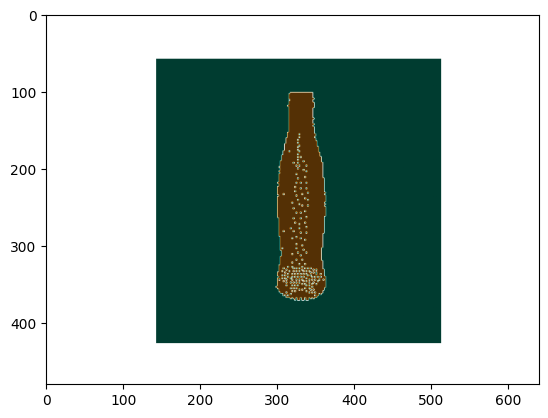

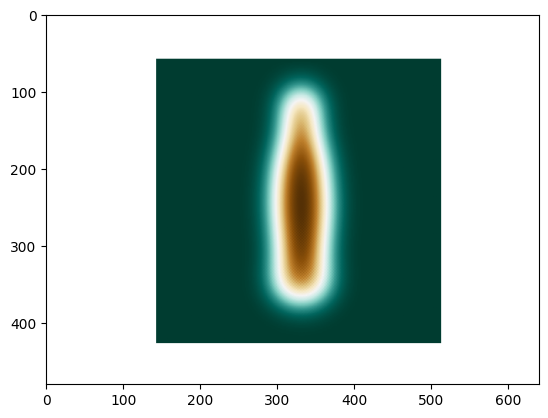

In [18]:
# importing pyplot and image from matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

# reading png image file
im1 = img.imread('heat_000.png')
im2 = img.imread('heat_200.png')
# show image
plt.imshow(im1)
plt.figure()
plt.imshow(im2)

We can use ``pstats`` to pretty print profiling data generated by cProfile:

In [ ]:
!python -m pstats profile.data
# in the interactive console that opens, try the following commands in order:
# strip # removes the file paths from the function names
# sort time # sorts the profiling results by the amount of time spent in each function
# stats 5 # shows a summary of the top N functions based on the current sort order
# quit

Welcome to the profile statistics browser.
profile.data% strip
profile.data% sort time
profile.data% stats 5
Wed Dec 18 20:43:58 2024    profile.data

         1075386 function calls (1059121 primitive calls) in 24.477 seconds

   Ordered by: internal time
   List reduced from 3794 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      200   23.154    0.116   23.154    0.116 heat.py:9(evolve)
     7308    0.101    0.000    0.163    0.000 inspect.py:744(cleandoc)
      293    0.063    0.000    0.063    0.000 {built-in method marshal.loads}
        2    0.048    0.024    0.048    0.024 {method 'encode' of 'ImagingEncoder' objects}
        8    0.039    0.005    0.040    0.005 {built-in method matplotlib._image.resample}


profile.data% quit
Goodbye.


In [21]:
# pstats can also be called from within a script
from pstats import Stats

p = Stats('profile.data')
p.strip_dirs() # removes all leading path information from file names
p.sort_stats('time') # sort by computing time
p.print_stats(5) # show first 5 rows

Thu Jan  2 10:36:54 2025    profile.data

         1075386 function calls (1059121 primitive calls) in 22.122 seconds

   Ordered by: internal time
   List reduced from 3794 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      200   20.909    0.105   20.909    0.105 heat.py:9(evolve)
     7308    0.087    0.000    0.141    0.000 inspect.py:744(cleandoc)
      293    0.059    0.000    0.059    0.000 {built-in method marshal.loads}
        2    0.042    0.021    0.042    0.021 {method 'encode' of 'ImagingEncoder' objects}
        8    0.038    0.005    0.038    0.005 {built-in method matplotlib._image.resample}




### Using cProfile in an script

Another way of using cProfile is calling it from within a script:

In [19]:
# another way of using cProfile is calling it from within a script
import cProfile
cProfile.run('2+2')

         3 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [20]:
# another way of using cProfile is calling it from within a script
# Remember: if using a function call or script, enclose its name in ''
# Use 'sort' to sort by any of the report columns
import cProfile
cProfile.run('calculate(x)', sort='tottime')

         7 function calls in 0.029 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.028    0.028    0.029    0.029 <ipython-input-10-98921c597944>:4(calculate)
        1    0.001    0.001    0.001    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.029    0.029 {built-in method builtins.exec}
        1    0.000    0.000    0.001    0.001 {method 'sum' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.001    0.001 _methods.py:47(_sum)
        1    0.000    0.000    0.029    0.029 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [22]:
# cd to the defautl working dir before executing next cell
%cd /content/

/content


In [23]:
# Instead of printing the output at the end of the profile run,
# you can save the results to a file:
cProfile.run('calculate(x)', 'calculate_stats')

The `Stats` module can also be called from within an script:

In [24]:
from pstats import Stats
p = Stats('calculate_stats')
p.strip_dirs() # removes all leading path information from file names
p.sort_stats('time') # sort by computing time
p.print_stats(5) # show first 5 rows

Thu Jan  2 10:50:37 2025    calculate_stats

         7 function calls in 0.027 seconds

   Ordered by: internal time
   List reduced from 7 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.026    0.026    0.027    0.027 <ipython-input-10-98921c597944>:4(calculate)
        1    0.001    0.001    0.001    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.027    0.027 {built-in method builtins.exec}
        1    0.000    0.000    0.001    0.001 {method 'sum' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.001    0.001 _methods.py:47(_sum)




In [25]:
# this is typically combined in as a single-line command:
p.strip_dirs().sort_stats('time').print_stats(5)

Thu Jan  2 10:50:37 2025    calculate_stats

         7 function calls in 0.027 seconds

   Ordered by: internal time
   List reduced from 7 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.026    0.026    0.027    0.027 <ipython-input-10-98921c597944>:4(calculate)
        1    0.001    0.001    0.001    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.027    0.027 {built-in method builtins.exec}
        1    0.000    0.000    0.001    0.001 {method 'sum' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.001    0.001 _methods.py:47(_sum)




Typically, to profile your ML algorithms you will be using cProfile in a very basic configuration, like this:

```
def train_model():
  train_history = model.fit(...)

cProfile.run('train_model()', prof_stats, sort='tottime')
```




# Profiling a parallel (multiprocess) application



## `py-spy` profiler

`py-spy` (https://github.com/benfred/py-spy) is a lightweight sampling profiler for that can profile any Python program in execution, including those using multiple processes or threads. It does not require modifying the source code and can capture profiles of child processes.

`py-spy` works on Linux, OSX, Windows and FreeBSD.

`py-spy` works from the command line and takes either the PID of the program you want to sample from or the command line of the python program you want to run. py-spy has three subcommands record, top and dump:

- `record` stores profiles to a file using a flame graph.
- `top` shows a live view of what functions are taking the most time in your python program, similar to the Unix top command.
- `dump` displays the current call stack for each python thread.



In [27]:
!pip install py-spy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 32.1 MB/s eta 0:00:00


In [29]:
# cd to the cprofile directory to run the heat difussion example
%cd /content/hpc-python/performance/cprofile
# Run the profiler. The -- separates the arguments for py-spy from the command it will run:
!py-spy record -o profile.svg -- python heat_main.py

/content/hpc-python/performance/cprofile
py-spy> Sampling process 100 times a second. Press Control-C to exit.

Heat equation solver
Diffusion constant: 0.5
Input file: bottle.dat
Parameters
----------
  nx=200 ny=200 dx=0.01 dy=0.01
  time steps=200  image interval=4000
Simulation finished in 35.752339363098145 s

py-spy> Stopped sampling because process exited
py-spy> Wrote flamegraph data to 'profile.svg'. Samples: 3769 Errors: 0


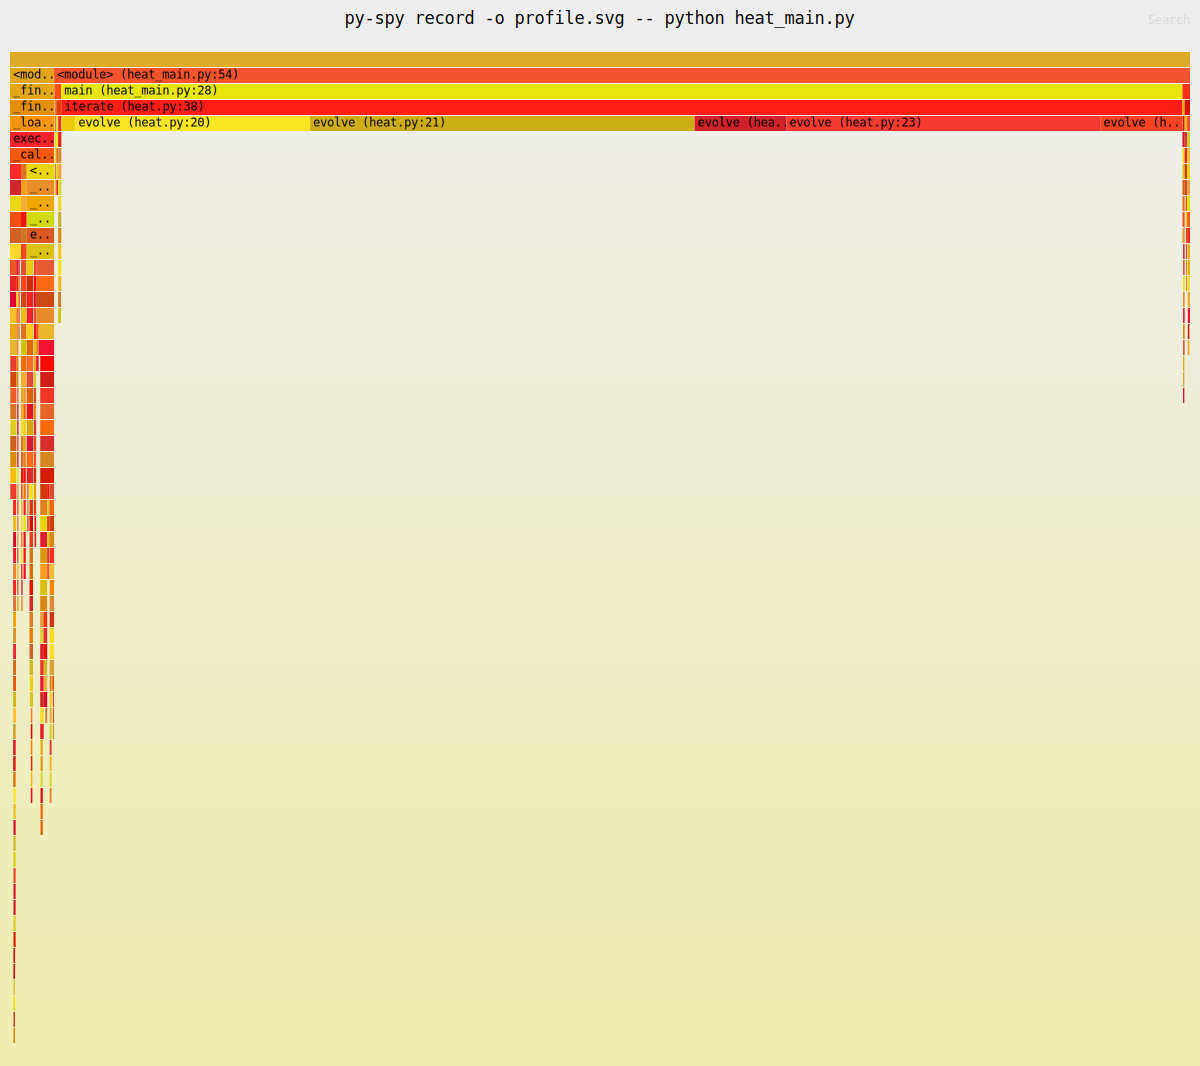

In [30]:
# open svg file with the flame graph
from IPython.display import SVG

SVG(filename='profile.svg')

In [ ]:
# interactive execution. This is similar to the `top` Linux command:
!py-spy top -- python heat_main.py


























Total Samples 10
GIL: 90.00%, Active: 100.00%, Threads: 1

  %Own   %Total  OwnTime  TotalTime  Function (filename)                        
 60.00%  60.00%   0.060s    0.060s   _ctypes (numpy/core/_internal.py)
 10.00%  10.00%   0.010s    0.010s   get_data (<frozen importlib._bootstrap_exte
 10.00%  10.00%   0.010s    0.010s   _init_module_attrs (<frozen importlib._boot
 10.00%  10.00%   0.010s    0.010s   find_spec (_distutils_hack/__init__.py)
 10.00%  10.00%   0.010s    0.010s   _binary_method (numpy/lib/mixins.py)
  0.00%  10.00%   0.000s    0.010s   <module> (numpy/lib/mixins.py)
  0.00%  20.00%   0.000s    0.020s   <module> (numpy/lib/__init__.py)
  0.00% 100.00%   0.000s    0.100s   <module> (heat_main.py)
  0.00%  80.00%   0.000s    0.080s   <module> (numpy/__config__.py)
  0.00% 100.00%   0.000s    0.100s   _handle_fromlist (<frozen importlib._bootst
  0.00%  10.00%   0.000s    0.010s   <module> (numpy/compat/__init__.py)
  0.00%  60.00%   0.000s    0.

## `scalene` profiler


`scalene` (https://github.com/plasma-umass/scalene) is a high-performance CPU, GPU and memory profiler for Python. It runs orders of magnitude faster than many other profilers while delivering far more detailed information.

Thanks to its GPU profiling support, it is extremely useful for machine learning and data processing applications. Scalene’s GPU profiling helps with underutilized GPUs as well as bottlenecks in parallel processing.

Scalene’s CPU profiling differentiates between the time spent in Python and the time spent in native code. NumPy and TensorFlow, two of the more popular libraries, have bottlenecks occurring outside of pure Python code.

Memory Profiling, which tracks Python and native memory usage, identifying leaks and excess allocations. While most profilers track only Python memory, Scalene measures usage in native extensions like C code that is called from Python. What this means is that it detects leaks and can pinpoint inefficient memory allocation patterns with great precision.

The meaning of main columns of the repor:

- "Time Python": How much time was spent in Python code.
"native": How much time was spent in non-Python code (e.g., libraries written in C/C++).
- "system": How much time was spent in the system (e.g., I/O).
- "GPU": (not shown here) How much time spent on the GPU, if your system has an NVIDIA GPU installed.
- "Memory Python": How much of the memory allocation happened on the Python side of the code, as opposed to in non-Python code (e.g., libraries written in C/C++).



In [31]:
!pip install scalene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.9 MB/s eta 0:00:00


In [32]:
# cd to the cprofile directory to run the heat difussion example
%cd /content/hpc-python/performance/cprofile
# run scalene to profile heat_main.py
!scalene heat_main.py

/content/hpc-python/performance/cprofile
Heat equation solver
Diffusion constant: 0.5
Input file: bottle.dat
Parameters
----------
  nx=200 ny=200 dx=0.01 dy=0.01
  time steps=200  image interval=4000
Simulation finished in 26.171640157699585 s
                       Memory usage: ▃▆█ (max: 31.011 MB, growth rate: 100%)                       
  /content/hpc-python/performance/cprofile/heat.py: % of time = 100.00% (27.904s) out of 27.904s.  
       ╷       ╷       ╷       ╷        ╷       ╷               ╷       ╷                          
       │Time   │–––––– │–––––– │Memory  │–––––– │–––––––––––    │Copy   │                          
  Line │Python │native │system │Python  │peak   │timeline/%     │(MB/s) │/content/hpc-python/per…  
╺━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━╸
     1 │       │       │       │        │       │               │       │import numpy as np        
     2 │       │       │       │        │       │      

Let's test scalene with our calculate() function:

In [35]:
# cd to the user dir
%cd /content/

/content


In [36]:
%%file calculate.py
import numpy as np

def calculate(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

x = np.random.uniform(-1, 1, 10000000)
print(f"result={calculate(x)}")

Writing calculate.py


In [1]:
# Run profiler
!scalene calculate.py

result=3317485.113207505
                      Memory usage: ▃▆█▆ (max: 228.924 MB, growth rate:  67%)                      
             /content/calculate.py: % of time = 100.00% (495.434ms) out of 495.434ms.              
       ╷       ╷       ╷       ╷        ╷       ╷               ╷       ╷                          
       │Time   │–––––– │–––––– │Memory  │–––––– │–––––––––––    │Copy   │                          
  Line │Python │native │system │Python  │peak   │timeline/%     │(MB/s) │/content/calculate.py     
╺━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━╸
     1 │       │       │       │        │       │               │       │import numpy as np        
     2 │       │       │       │        │       │               │       │                          
     3 │       │       │       │        │       │               │       │def calculate(a):         
     4 │       │       │       │        │       │               │       │  

**Explanation**: most of the time is spent inside `calculate()` function, although creating the large `x` array also accounts for a portion of the time. Within `calculate()`, the mayority of the time is consumed by the computation of `vector`, with a smaller portion spent on `vector.sum`. Notably, the time used for computing `vector` is predominantly attributed to native (C code) operations and secondly to system-level (I/O-bound) processes, rather than Python execution.  

This is a detailed explanation of the columns:

1. **Memory Usage and Histogram**  
   - The memory usage histogram visualizes how memory usage fluctuates throughout the script.  
   - **Max Memory**: is the maximum memory the script used.  
   - **Growth Rate**: indicates the increase in memory allocation over time.

2. **Execution Time**  
   - **File**: `/content/calculate.py`  
   - **% of Time**: 100% of the execution time was spent in this file.  
   - **Total Time**: total execution time.

3. **Line-by-Line Profiling**
    - **`Time (Python)`**: Percentage of time spent executing Python code on that line.
    - **`Time (native)`**: Time spent in native extensions like NumPy.
    - **`Time (system)`**: System-level time (e.g., OS operations like file I/O).
    - **`Memory (Python)`**: Memory usage attributed to Python objects for that line.
    - **`Peak Memory`**: Peak memory usage for that line during execution.
    - **`Timeline/%`**: The relative contribution of that line to the total execution time, visualized as a bar graph.
    - **`Copy (MB/s)`**: Memory copy bandwidth for operations involving arrays or buffers.
